# Setup (only on collab)

!git clone https://github.com/alicebarbosam/fraud-detection-kaggle.git
%cd fraud-detection-kaggle

# Setup

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import optuna
import joblib
import os


In [12]:
df = pd.read_csv("../data/train.csv")

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (227845, 32)
       id      Time        V1        V2        V3        V4        V5  \
0  265519  161919.0  1.946747 -0.752526 -1.355130 -0.661630  1.502822   
1  180306  124477.0  2.035149 -0.048880 -3.058693  0.247945  2.943487   
2   42665   41191.0 -0.991920  0.603193  0.711976 -0.992425 -0.825838   
3  198724  132624.0  2.285718 -1.500239 -0.747565 -1.668119 -1.394143   
4   82326   59359.0 -0.448747 -1.011440  0.115903 -3.454854  0.715771   

         V6        V7        V8  ...       V21       V22       V23       V24  \
0  4.024933 -1.479661  1.139880  ...  0.076197  0.297537  0.307915  0.690980   
1  3.298697 -0.002192  0.674782  ...  0.038628  0.228197  0.035542  0.707090   
2  1.956261 -2.212603 -5.037523  ... -2.798352  0.109526 -0.436530 -0.932803   
3 -0.350339 -1.427984  0.010010  ... -0.139670  0.077013  0.208310 -0.538236   
4 -0.147490  0.504347 -0.113817  ... -0.243245 -0.173298 -0.006692 -1.362383   

        V25       V26       V27       V28  Amount  C

# Pre processing

In [13]:
target = "Class"

X = df.drop(columns=["id", target])
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Fraud rate (overall):", y.mean())

X shape: (227845, 30)
y shape: (227845,)
Fraud rate (overall): 0.001729245759178389


In [14]:
#split treino e val
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, "| Fraud rate:", y_train.mean())
print("Val size:", X_val.shape, "| Fraud rate:", y_val.mean())


Train size: (182276, 30) | Fraud rate: 0.0017281485220215498
Val size: (45569, 30) | Fraud rate: 0.0017336347078057452


# Evaluation function

In [17]:
results = []

def evaluate_model(model, X_val, y_val, model_name="Model"):

    val_probs = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, val_probs)

    print(f"{model_name} ROC-AUC: {roc_auc:.4f}")

    results.append({
        "model": model_name,
        "roc_auc": roc_auc
    })

    return roc_auc

# MODEL 1(Baseline) - Logistic Regression

In [ ]:
baseline_model = Pipeline([
    ("scaler", StandardScaler()),  
    ("lr", LogisticRegression(
        max_iter=5000,              
        class_weight="balanced"
    ))
])

baseline_model.fit(X_train, y_train)

evaluate_model(
    baseline_model,
    X_val,
    y_val,
    "Logistic Regression (scaled baseline)"
)

Logistic Regression (scaled baseline) ROC-AUC: 0.9736


0.973616401991257

# MODEL 2 - Random forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=800,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample",
    max_features="sqrt",
    max_depth=18,
    min_samples_split=10,
    min_samples_leaf=5
)

rf_model.fit(X_train, y_train)

evaluate_model(
    rf_model,
    X_val,
    y_val,
    "Random Forest"
)

Random Forest ROC-AUC: 0.9689


0.9689318281107825

# MODEL 3 - HistGradientBoosting

In [ ]:


hgb_model = HistGradientBoostingClassifier(
    loss="log_loss",
    max_iter=600,
    learning_rate=0.02,
    max_depth=6,
    l2_regularization=0.1,
    random_state=42
)

hgb_model.fit(X_train, y_train)

evaluate_model(
    hgb_model,
    X_val,
    y_val,
    "HistGradientBoosting (stronger)"
)

HistGradientBoosting (stronger) ROC-AUC: 0.9826


0.9825879105437

# MODEL 4 - XGBOOST


In [33]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
spw = neg / pos

xgb_model = XGBClassifier(
    n_estimators=15000,
    learning_rate=0.02,
    max_depth=7,
    min_child_weight=6,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=5.0,
    reg_alpha=0.1,
    gamma=0.1,
    scale_pos_weight=spw,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=200,
)

evaluate_model(xgb_model, X_val, y_val, "XGBoost (baseline)")

[0]	validation_0-auc:0.96276
[200]	validation_0-auc:0.96910
[400]	validation_0-auc:0.97430
[600]	validation_0-auc:0.97459
[800]	validation_0-auc:0.97515
[1000]	validation_0-auc:0.97452
[1200]	validation_0-auc:0.97426
[1400]	validation_0-auc:0.97392
[1600]	validation_0-auc:0.97470
[1800]	validation_0-auc:0.97504
[2000]	validation_0-auc:0.97539
[2200]	validation_0-auc:0.97576
[2400]	validation_0-auc:0.97580
[2600]	validation_0-auc:0.97603
[2800]	validation_0-auc:0.97586
[3000]	validation_0-auc:0.97589
[3200]	validation_0-auc:0.97600
[3400]	validation_0-auc:0.97607
[3600]	validation_0-auc:0.97595
[3800]	validation_0-auc:0.97623
[4000]	validation_0-auc:0.97604
[4200]	validation_0-auc:0.97649
[4400]	validation_0-auc:0.97642
[4600]	validation_0-auc:0.97643
[4800]	validation_0-auc:0.97646
[5000]	validation_0-auc:0.97649
[5200]	validation_0-auc:0.97647
[5400]	validation_0-auc:0.97666
[5600]	validation_0-auc:0.97684
[5800]	validation_0-auc:0.97692
[6000]	validation_0-auc:0.97696
[6200]	validati

0.9773860439490109

# MODEL 5 - HGB + CV

In [ ]:


X = df.drop(columns=["id", "Class"])
y = df["Class"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), start=1):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    model = HistGradientBoostingClassifier(
        loss="log_loss",
        max_iter=600,
        learning_rate=0.02,
        max_depth=6,
        l2_regularization=0.1,
        random_state=42
    )

    model.fit(X_train_cv, y_train_cv)

    val_probs = model.predict_proba(X_val_cv)[:, 1]
    fold_auc = roc_auc_score(y_val_cv, val_probs)

    auc_scores.append(fold_auc)
    print(f"Fold {fold} ROC-AUC: {fold_auc:.6f}")

auc_scores = np.array(auc_scores)

print("\nHGB CV ROC-AUC Mean:", auc_scores.mean())
print("HGB CV ROC-AUC Std:", auc_scores.std())
print("HGB CV ROC-AUC Mean ± Std:", f"{auc_scores.mean():.6f} ± {auc_scores.std():.6f}")

Fold 1 ROC-AUC: 0.988676
Fold 2 ROC-AUC: 0.972383
Fold 3 ROC-AUC: 0.972632
Fold 4 ROC-AUC: 0.991376
Fold 5 ROC-AUC: 0.981617

HGB CV ROC-AUC Mean: 0.9813369333403081
HGB CV ROC-AUC Std: 0.007882309892227303
HGB CV ROC-AUC Mean ± Std: 0.981337 ± 0.007882


# MODEL 5 - XGBOOST + CV

In [34]:
neg = (y == 0).sum()
pos = (y == 1).sum()
spw = neg / pos

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), start=1):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBClassifier(
        n_estimators=12000,
        learning_rate=0.02,
        max_depth=5,
        min_child_weight=12,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=8.0,
        reg_alpha=0.0,
        gamma=0.0,
        scale_pos_weight=spw,
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    )

    model.fit(
        X_train_cv,
        y_train_cv,
        eval_set=[(X_val_cv, y_val_cv)],
        verbose=False
    )

    val_probs = model.predict_proba(X_val_cv)[:, 1]
    fold_auc = roc_auc_score(y_val_cv, val_probs)

    auc_scores.append(fold_auc)
    print(f"Fold {fold} ROC-AUC: {fold_auc:.6f}")

auc_scores = np.array(auc_scores)

print("\nXGB CV ROC-AUC Mean:", auc_scores.mean())
print("XGB CV ROC-AUC Std:", auc_scores.std())
print("XGB CV ROC-AUC Mean ± Std:", f"{auc_scores.mean():.6f} ± {auc_scores.std():.6f}")

Fold 1 ROC-AUC: 0.996268
Fold 2 ROC-AUC: 0.974153
Fold 3 ROC-AUC: 0.976748
Fold 4 ROC-AUC: 0.994501
Fold 5 ROC-AUC: 0.981157

XGB CV ROC-AUC Mean: 0.9845654497882943
XGB CV ROC-AUC Std: 0.009130043051260611
XGB CV ROC-AUC Mean ± Std: 0.984565 ± 0.009130


# MODEL 6 - XGBOOST + OPTUNA + CV

In [ ]:


X = df.drop(columns=["id", "Class"])
y = df["Class"]

neg = (y == 0).sum()
pos = (y == 1).sum()
spw = neg / pos

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 5000, 20000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.06, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 30),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 20.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
    }

    fold_aucs = []

    for train_idx, val_idx in cv.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBClassifier(
            **params,
            scale_pos_weight=spw,
            objective="binary:logistic",
            eval_metric="auc",
            tree_method="hist",
            random_state=42,
            n_jobs=-1
        )

        model.fit(X_train_cv, y_train_cv, verbose=False)

        val_probs = model.predict_proba(X_val_cv)[:, 1]
        fold_auc = roc_auc_score(y_val_cv, val_probs)
        fold_aucs.append(fold_auc)

    return float(np.mean(fold_aucs))


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("\nBest CV ROC-AUC:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

/Users/abm6/Desktop/projetos/fraud-detection-kaggle/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-02-19 21:18:01,931] A new study created in memory with name: no-name-e7dbbf0b-56bd-448b-bf41-640ae1a87f48
[I 2026-02-19 21:20:20,886] Trial 0 finished with value: 0.9853409575673048 and parameters: {'n_estimators': 11319, 'learning_rate': 0.01322261614156472, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.688702659006749, 'colsample_bytree': 0.6544210435172934, 'reg_lambda': 10.852913273335565, 'reg_alpha': 8.887608537441101e-05, 'gamma': 1.1544099949410547}. Best is trial 0 with value: 0.9853409575673048.
[I 2026-02-19 21:23:07,920] Trial 1 finished with value: 0.9860570129997018 and parameters: {'n_estimators': 13280, 'learning_rate': 0.013816785849589374, 'max_depth': 3, 'min_child


Best CV ROC-AUC: 0.9881910767195821
Best params:
  n_estimators: 18460
  learning_rate: 0.059630773223374595
  max_depth: 8
  min_child_weight: 30
  subsample: 0.8638973220871323
  colsample_bytree: 0.704838002168074
  reg_lambda: 0.053813329656442845
  reg_alpha: 2.737776706334933e-07
  gamma: 1.9564355338957067


# FINAL MODEL - (XGB + CV + OPTUNA) 


In [48]:
# usando todos os dadosa de treino
train_df = pd.read_csv("../data/train.csv")

X_train_full = train_df.drop(columns=["id", "Class"])
y_train_full = train_df["Class"]

# scale_pos_weight do treino completo
neg = (y_train_full == 0).sum()
pos = (y_train_full == 1).sum()
spw = neg / pos

# melhores parametros descobertos por optuna
best_params = {
    "n_estimators": 25000,
    "learning_rate": 0.03,
    "max_depth": 8,
    "min_child_weight": 30,
    "subsample": 0.8638973220871323,
    "colsample_bytree": 0.704838002168074,
    "reg_lambda": 0.053813329656442845,
    "reg_alpha": 2.737776706334933e-07,
    "gamma": 1.9564355338957067,
}

final_model = XGBClassifier(
    **best_params,
    scale_pos_weight=spw,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds = 800,
)


# pequeno split so p early stopping
X_tr, X_es, y_tr, y_es = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.1,
    stratify=y_train_full,
    random_state=42
)

final_model.fit(
    X_tr,
    y_tr,
    eval_set=[(X_es, y_es)],
    verbose=200
)

# Save model
os.makedirs("../models", exist_ok=True)
joblib.dump(final_model, "../models/xgb_optuna_final.joblib")
final_model.save_model("../models/xgb_optuna_final.json")

print("Saved model artifacts:")
print(" - ../models/xgb_optuna_final.joblib")
print(" - ../models/xgb_optuna_final.json")

[0]	validation_0-auc:0.83480
[200]	validation_0-auc:0.97139
[400]	validation_0-auc:0.97059
[600]	validation_0-auc:0.96906
[800]	validation_0-auc:0.97002
[983]	validation_0-auc:0.97105
Saved model artifacts:
 - ../models/xgb_optuna_final.joblib
 - ../models/xgb_optuna_final.json


# XAI

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If your dataset is big, use a sample for interpretability plots
# (SHAP can be slow on full data)
SAMPLE_SIZE = 3000
X_sample = X_es.sample(SAMPLE_SIZE, random_state=42) if "X_es" in globals() else X_train_full.sample(SAMPLE_SIZE, random_state=42)

In [ ]:
#feature importance
booster = final_model.get_booster()

importance_gain = booster.get_score(importance_type="gain")
importance_weight = booster.get_score(importance_type="weight")

imp_gain = (
    pd.DataFrame({"feature": list(importance_gain.keys()), "gain": list(importance_gain.values())})
    .sort_values("gain", ascending=False)
)

imp_weight = (
    pd.DataFrame({"feature": list(importance_weight.keys()), "weight": list(importance_weight.values())})
    .sort_values("weight", ascending=False)
)

display(imp_gain.head(15))
display(imp_weight.head(15))

,feature,gain
14,V14,5643.609375
10,V10,2289.674561
12,V12,1118.883423
4,V4,891.702881
17,V17,622.987671
3,V3,434.273499
8,V8,301.559662
20,V20,281.833344
19,V19,245.241196
13,V13,245.060577


,feature,weight
4,V4,731.0
26,V26,717.0
14,V14,698.0
0,Time,586.0
29,Amount,556.0
12,V12,546.0
10,V10,533.0
13,V13,532.0
11,V11,520.0
16,V16,514.0


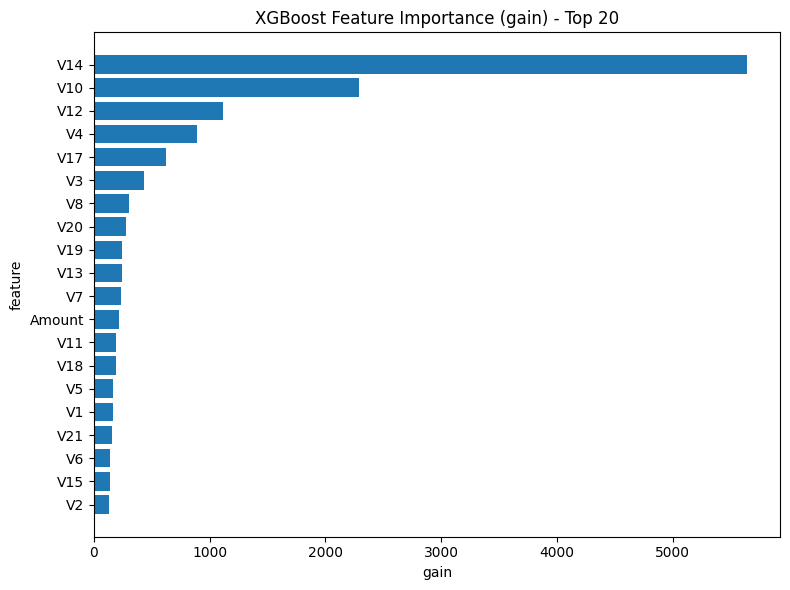

In [ ]:
TOP_N = 20
top_imp = imp_gain.head(TOP_N).sort_values("gain", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(top_imp["feature"], top_imp["gain"])
plt.title(f"XGBoost Feature Importance (gain) - Top {TOP_N}")
plt.xlabel("gain")
plt.ylabel("feature")
plt.tight_layout()
plt.show()

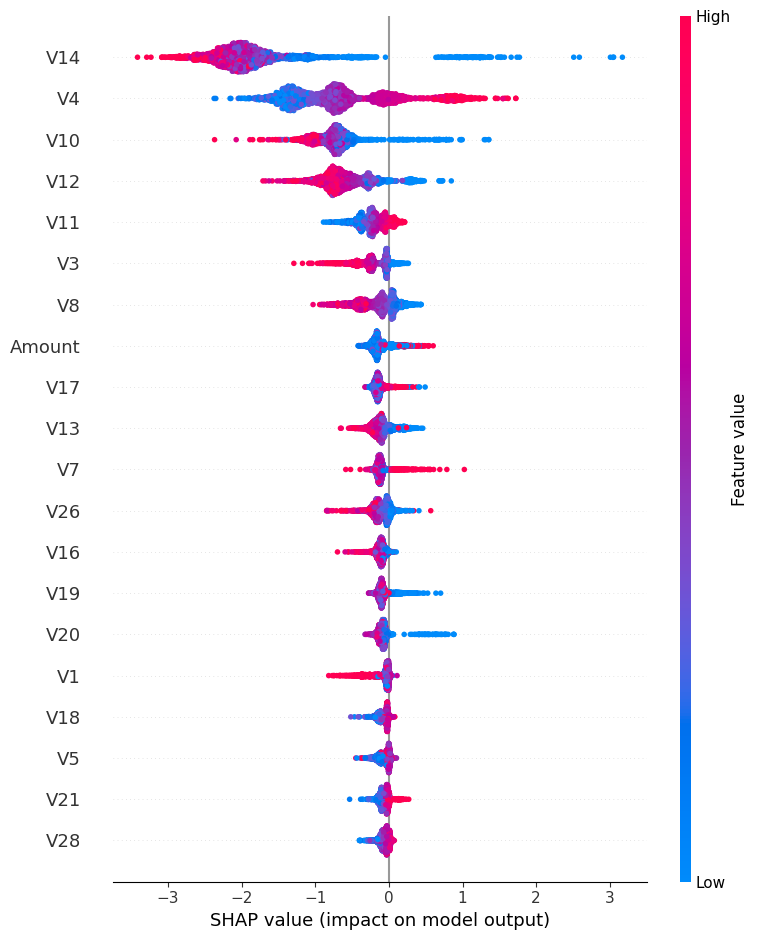

In [ ]:
import shap
#explicabilidade
explainer = shap.TreeExplainer(final_model)

shap_values = explainer.shap_values(X_sample)

#plot do global importance
shap.summary_plot(shap_values, X_sample, show=True)

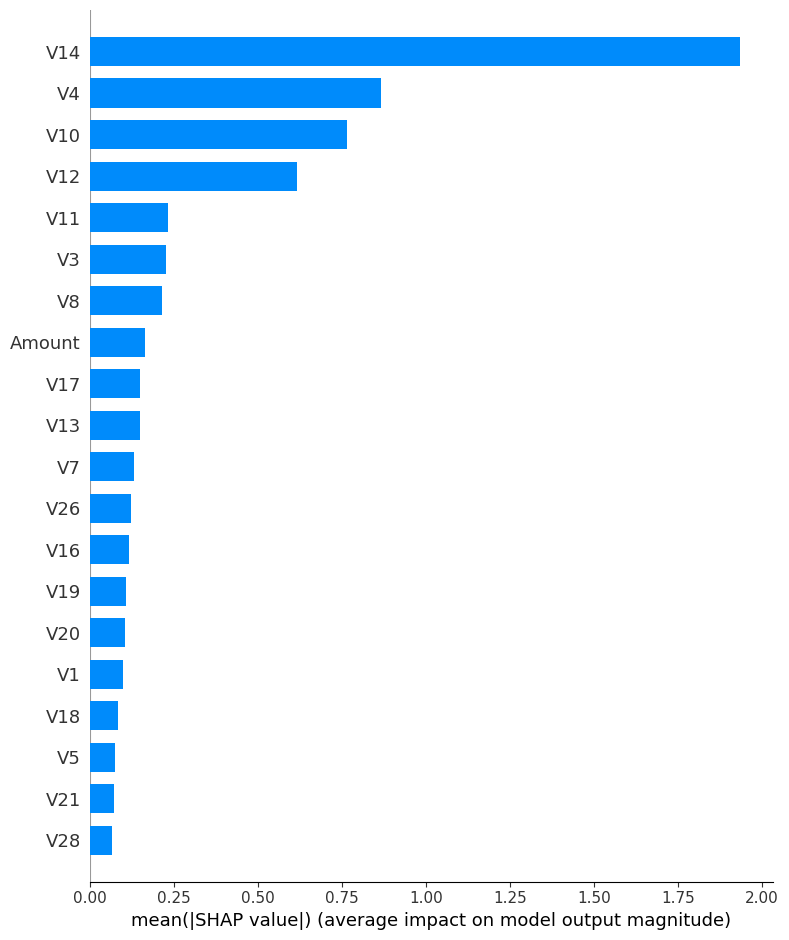

In [74]:
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)

Top SHAP feature: V14


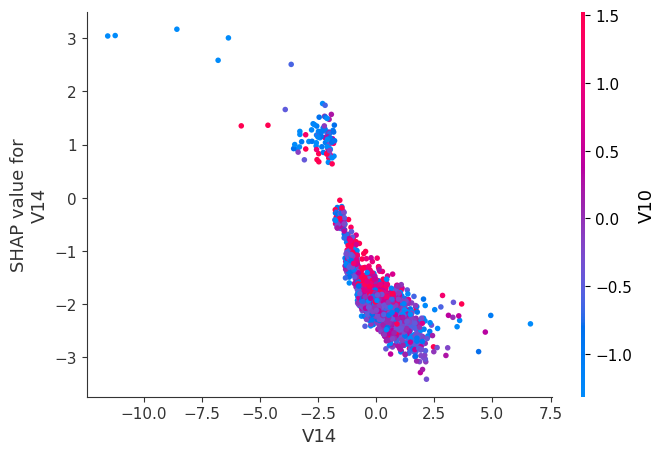

In [75]:
# Pick the top feature from SHAP (global mean |SHAP|)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_feature = X_sample.columns[np.argmax(mean_abs_shap)]
print("Top SHAP feature:", top_feature)

# Shows how feature value relates to SHAP impact (and possible interactions)
shap.dependence_plot(top_feature, shap_values, X_sample, show=True)

Chosen index: 1530
Predicted probability: 0.99780875


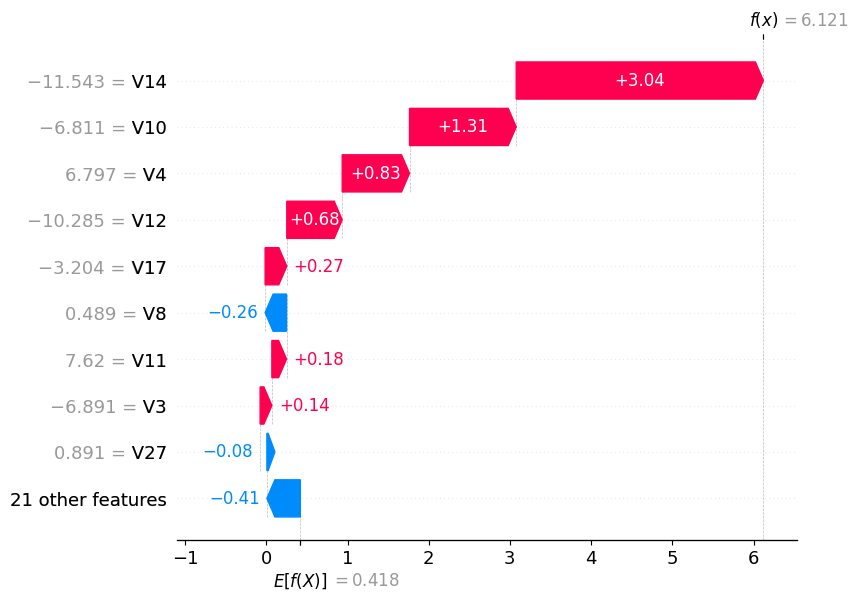

In [ ]:
# Find a high-risk example in the sample (highest predicted probability)
probs_sample = final_model.predict_proba(X_sample)[:, 1]
idx = int(np.argmax(probs_sample))

print("Chosen index:", idx)
print("Predicted probability:", probs_sample[idx])


try:
    shap_explanation = explainer(X_sample.iloc[[idx]])
    shap.plots.waterfall(shap_explanation[0])
except Exception as e:
    print("Waterfall plot failed with this SHAP version:", e)
    shap.force_plot(explainer.expected_value, shap_values[idx, :], X_sample.iloc[idx, :], matplotlib=True)